# Test Confidence Values 90-100 for Hour Network

/mnt/data2016/ \
2016-07-21T15:00:00Z \
       60 \
       conf \
       212 \
       3 \
       8 \
       2016-07-21T15:00:00Z_1h_allCams-conf \
       2016 \
       2
       
Check Number of Nodes and check weather the bee/node should exist

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [344]:
import networkx as nx
import os
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from collections import namedtuple
from bb_binary import FrameContainer, Repository, load_frame_container
import numpy as np
import numpy.ma as npma
import datetime
import csv
import seaborn as sns
from collections import Counter
import hatching as ht
import seaborn as sns

In [289]:
graphml = []
liste = os.listdir()

for file in liste:
    if file.endswith(".graphml"):
            graphml.append(file)

In [296]:
graphml

['2016-07-21T15:00:00Z_1h_allCams-97_0.97conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-93_0.93conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-94_0.94conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-99_0.99conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-90_0.9conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-96_0.96conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-95_0.95conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-98_0.98conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-91_0.91conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-92_0.92conf_212dist_3ilen.graphml']

In [290]:
start = "2016-07-21T16:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [291]:
list_nodes = []
for f in graphml:
    c = int(f.split('Cams-')[1].split('_')[0])
    G = nx.read_graphml(f)
    n = list(G.node)
    list_nodes.append((c,n))

In [292]:
aa.head()

,dec12,birthdate,age
0,0,NaT,-1
1,1,2016-07-28,-7
2,2,NaT,-1
3,3,2016-07-06,15
4,4,2016-08-22,-32


In [293]:
aa = ht.get_all_bees_age(start_dt)

In [294]:
stat = []
for c, n in list_nodes:
    ids = DataFrame(n, columns=['id'], dtype='int')
    ids["age"] = ids.id.apply(lambda x: aa.iloc[x].age)
    total = ids.shape[0]
    wrong = len(ids[ids.age < 0])
    stat.append((c,total,wrong, wrong/total))

In [295]:
DataFrame(stat, columns=['conf', 'total', 'wrong', 'wrongP'])

,conf,total,wrong,wrongP
0,97,1436,510,0.355153
1,93,1749,784,0.448256
2,94,1705,747,0.438123
3,99,1228,315,0.256515
4,90,1916,937,0.489040
5,96,1580,636,0.402532
6,95,1648,697,0.422937
7,98,1337,418,0.312640
8,91,1880,906,0.481915
9,92,1837,866,0.471421


In [169]:
%matplotlib inline

# Test Networks and Quality complete Pipeline :(

In [456]:
s = "2016-07-21T16:00:00Z"
s_dt = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
s_ts = s_dt.timestamp()

In [457]:
e_dt = s_dt + datetime.timedelta(minutes=5)
e_ts = e_dt.timestamp()

In [458]:
path = "/mnt/data2016/"
b = s_ts
e = e_ts
confidence = 0.95
distance = 212
ilen = 3
year = 2016
gap = 2

In [459]:
repo = Repository(path)
xmax = 3000
offset = 200
    
Detection = namedtuple('Detection', ['idx', 'xpos', 'ypos', 'radius', 'zRotation', 'decodedId', 'frame_idx', 'timestamp', 'cam_id', 'fc_id'])

# one df per cam
parts = np.empty(4, dtype=object)

for i in list(range(4)):

    tpls = []
    myid = 0


    for frame, fc in repo.iter_frames(begin=b, end=e, cam=i):
        for d in frame.detectionsUnion.detectionsDP:
            d = Detection(d.idx, d.xpos, d.ypos, d.radius, d.zRotation, list(d.decodedId), myid, frame.timestamp, fc.camId, fc.id)
            tpls.append(d)
        myid += 1

    df = DataFrame(tpls)
    parts[i] = df

In [460]:
partsid = np.empty(4, dtype=object)

for i in list(range(4)):    
    partsid[i] = prep.calcIds(parts[i], confidence, year)

In [461]:
partsid[1].xpos = partsid[1].xpos + xmax + offset
partsid[3].xpos = partsid[3].xpos + xmax + offset

In [462]:
side0 = pd.concat([partsid[0], partsid[1]])
side1 = pd.concat([partsid[2], partsid[3]])

In [463]:
side = pd.concat([side0,side1])

In [288]:
# ID Königin

side[side.id == 2988]

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,confidence,id,age


# Detectionen

## Alter der einzelnen Detections bestimmen

In [179]:
def getNegatives(df):
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return len(df[df.age < 0])

In [180]:
numNegDetections = getNegatives(side)

In [181]:
numNegDetections

4544

In [182]:
numNegDetections/side.shape[0]

0.02126982343799734

## Alter der IDs

In [183]:
allids = DataFrame(side.id.unique(), columns=['id'])

In [184]:
allids.shape[0]

1442

In [185]:
numNegIDs = getNegatives(allids)

In [186]:
numNegIDs

653

In [187]:
numNegIDs/allids.shape[0]

0.45284327323162277

## Falsche Ids haben wenige Detections, Korrekte IDs haben viele Detections?

In [188]:
wrongdetections = side[side.age <0]

In [189]:
wrongdetections.id.value_counts().median()

1.0

In [190]:
correctdetections = side[side.age >= 0]

In [191]:
correctdetections.id.value_counts().median()

247.0

In [192]:
len(correctdetections.id.unique())

789

In [193]:
len(wrongdetections.id.unique())

653

# Detectionen von Paaren

In [194]:
close1 = prep.get_close_bees_ckd(side0, distance)
close2 = prep.get_close_bees_ckd(side1, distance)

close = pd.concat([close1,close2])

## Alter der Detectionen von den Paaren bestimmen

In [195]:
close['age_x'] = close.id_x.apply(lambda x: aa.iloc[x].age)
close['age_y'] = close.id_y.apply(lambda x: aa.iloc[x].age)

In [196]:
close.shape[0]

85437

In [197]:
numNegPairDet = len(close.query('age_x < 0 or age_y < 0'))

In [198]:
numNegPairDet

3772

In [199]:
numNegPairDet/close.shape[0]

0.04414949026768262

## Alter der IDs von den Paaren bestimmen

In [200]:
idx = list(close.id_x.unique())
idy= list(close.id_y.unique())

In [201]:
allPairIds = DataFrame(Series(idx + idy).unique(), columns=['id'])

In [202]:
allPairIds.shape[0]

1207

In [203]:
numNegPairIds = getNegatives(allPairIds)

In [204]:
numNegPairIds

463

In [205]:
numNegPairIds/allPairIds.shape[0]

0.3835956917978459

# Pair Time Series

In [206]:
p = prep.bee_pairs_to_timeseries(close)

In [207]:
p.head(2)

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(2676, 4068)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(297, 797)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Alter der Paare bestimmen

In [208]:
alterPaare = DataFrame([((aa.iloc[a].age), aa.iloc[b].age, a, b) for a,b in p.index.values], columns=['age_x', 'age_y', 'id_x', 'id_y'])

In [209]:
numNegPairSer = len(alterPaare.query('age_x < 0 or age_y < 0'))

In [210]:
numNegPairSer

1412

In [211]:
alterPaare.shape[0]

13528

In [212]:
numNegPairSer/alterPaare.shape[0]

0.10437610881135423

## Alter der IDs von den Paaren bestimmen

In [213]:
seriesIDs = DataFrame(Series([a for a,b in list(p.index)] + [b for a,b in list(p.index)]).unique(), columns=['id'])

In [214]:
numNegSerIDs = getNegatives(seriesIDs)

In [215]:
numNegSerIDs

463

In [216]:
seriesIDs.shape[0]

1207

In [217]:
numNegSerIDs/seriesIDs.shape[0]

0.3835956917978459

## Time Series of wrong paare mal anschauen

In [218]:
negativePairs = alterPaare.query('age_x < 0 or age_y < 0')

In [219]:
nP = list(zip(negativePairs.id_x, negativePairs.id_y))

In [220]:
NP = p[p.index.isin(nP)]

In [221]:
NP.apply(sum, axis=1).mean()

2.6012747875354107

In [222]:
NP.apply(sum, axis=1).median()

1.0

In [223]:
NP.apply(sum, axis=1).mode()

0    1
dtype: int64

In [224]:
positivePairs = alterPaare.query('age_x >= 0 and age_y >= 0')

In [225]:
pP = list(zip(positivePairs.id_x, positivePairs.id_y))

In [226]:
PP = p[p.index.isin(pP)]

In [227]:
PP.apply(sum, axis=1).mean()

6.7117860680092436

In [228]:
NP.apply(sum, axis=1).median()

1.0

In [229]:
NP.apply(sum, axis=1).mode()

0    1
dtype: int64

# Coorect pair time series

In [230]:
p_corrected = p.apply(prep.fill_gaps, axis=1, args=[gap])

In [231]:
p_corrected.head(2)

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(2676, 4068)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(297, 797)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Time Series of wrong paare corrigiert mal anschauen

In [232]:
nPC = p_corrected[p_corrected.index.isin(nP)]

In [233]:
nPC.apply(sum, axis=1).mean()

2.9985835694050991

In [234]:
pPC = p_corrected[p_corrected.index.isin(pP)]

In [235]:
pPC.apply(sum, axis=1).mean()

8.4002971277649383

# Interaktionen

In [236]:
interactions = prep.extract_interactions(p_corrected,ilen)

In [237]:
df = DataFrame(interactions.tolist(), columns=['frequency', 'totalduration', 'durations'], index=interactions.index)

In [238]:
df.head(2)

,frequency,totalduration,durations
"(297, 3402)",1,4,[4]
"(2117, 3123)",1,5,[5]


## Alter der Interaktionen anschauen

In [239]:
numNegInteractions = len(df[df.index.isin(nP)])

In [240]:
numNegInteractions

191

In [241]:
df.shape[0]

7362

In [242]:
numNegInteractions/df.shape[0]

0.025944036946481935

## Frequency and Total Duration of negative Interactons

In [258]:
negativeInteractions = df[df.index.isin(nP)]

In [279]:
negativeInteractions.frequency.quantile(q=0.65)

2.0

In [283]:
negativeInteractions.totalduration.quantile(q=0.80)

16.0

In [284]:
negativeInteractions

,frequency,totalduration,durations
"(1406, 2045)",1,4,[4]
"(2054, 3180)",1,4,[4]
"(1751, 2868)",1,4,[4]
"(238, 2478)",2,7,"[3, 4]"
"(1014, 2478)",3,10,"[3, 3, 4]"
"(2045, 2139)",1,3,[3]
"(870, 918)",4,33,"[4, 10, 8, 11]"
"(622, 2045)",1,7,[7]
"(1751, 2429)",8,69,"[4, 14, 3, 5, 4, 3, 18, 18]"
"(1751, 2890)",3,14,"[4, 5, 5]"


## Alter der IDs der Interaktionen anschauen

In [243]:
idInter = DataFrame(Series([a for a,b in list(df.index)] + [b for a,b in list(df.index)]).unique(), columns=['id'])

In [244]:
numNegInterIDs = getNegatives(idInter)

In [245]:
numNegInterIDs

40

In [246]:
idInter.shape[0]

735

In [247]:
numNegInterIDs/idInter.shape[0]

0.05442176870748299

# Graph bauen

In [248]:
G = prep.create_graph2(interactions)

In [249]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 735\nNumber of edges: 7362\nAverage degree:  20.0327'

In [250]:
ids = DataFrame(list(G.node), columns=['id'], dtype='int')

In [251]:
numNegNodes = getNegatives(ids)

In [252]:
numNegNodes

40

# Degree of wrong Nodes

In [253]:
negativeNodes = list(ids[ids.age < 0].id)

In [254]:
positiveNodes = list(ids[ids.age >= 0].id)

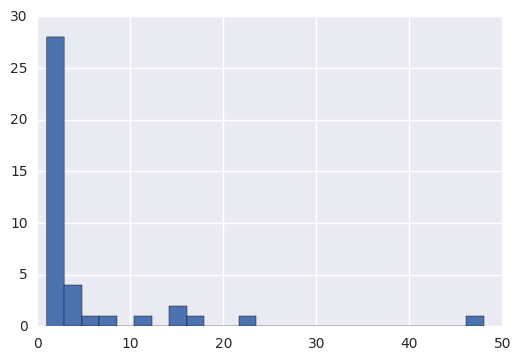

In [255]:
Series(G.degree(negativeNodes)).hist(bins=25)

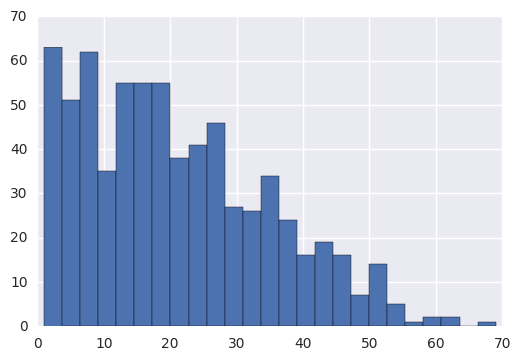

In [256]:
Series(G.degree(positiveNodes)).hist(bins=25)

In [297]:
G2 = nx.read_graphml('2016-07-21T15:00:00Z_1h_allCams-90_0.9conf_212dist_3ilen.graphml')

In [306]:
n2 = set(list(G2.node))

In [316]:
'2988' in n2

False

In [317]:
aa.iloc[2988].age

-33

# Wie oft wurde eine ID detectiert

In [464]:
idstat = side.groupby(by='id').size()

In [465]:
from scipy import stats

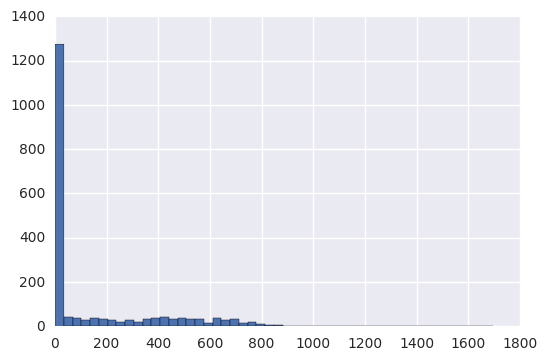

In [466]:
idstat.hist(bins=50)

In [467]:
m = idstat.mean()

In [468]:
m

147.28044466902475

In [469]:
def getPositives(df):
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return len(df[df.age >= 0])

In [ ]:
def removeDetections(df, cutoff=10):
    idstat = df.groupby(by='id').size()
    m = idstat.mean()
    boder = cutoff*m/100
    trashIDs = idstat[idstat < border]
    
    # remove detections with trashIDs from df
    

In [470]:
mystat = []
for i in np.arange(100+1):
    border = i*m/100
    
    restGut = idstat[idstat >= border]
    idxGut = DataFrame(list(restGut.index.values), columns=['id'])
    negativesGut = getNegatives(idxGut)
    
    restBoese = idstat[idstat < border]
    idxBoese = DataFrame(list(restBoese.index.values), columns=['id'])
    positivesBoese = getPositives(idxBoese)
    
    mystat.append((i,border, len(restGut), negativesGut, len(restBoese), positivesBoese))   

In [471]:
dfmystat = DataFrame(mystat, columns=['i', 'border', 'restids', 'negatives', 'muellids', 'positives'])

In [498]:
dfmystat.head(12)

,i,border,restids,negatives,muellids,positives,restidsP,negP,muellidsP,posP
0,0,0.000000,1979,1085,0,0,100.000000,54.825670,0.000000,0.000000
1,1,1.472804,1453,672,526,113,73.420920,33.956544,26.579080,5.709955
2,2,2.945609,1210,456,769,140,61.141991,23.041940,38.858009,7.074280
3,3,4.418413,1023,289,956,160,51.692774,14.603335,48.307226,8.084891
4,4,5.891218,968,241,1011,167,48.913593,12.177868,51.086407,8.438605
5,5,7.364022,894,173,1085,173,45.174330,8.741789,54.825670,8.741789
6,6,8.836827,861,142,1118,175,43.506822,7.175341,56.493178,8.842850
7,7,10.309631,826,108,1153,176,41.738252,5.457302,58.261748,8.893380
8,8,11.782436,808,92,1171,178,40.828701,4.648813,59.171299,8.994442
9,9,13.255240,784,71,1195,181,39.615968,3.587671,60.384032,9.146033


In [455]:
dfmystat

,i,border,restids,negatives,muellids,positives,restidsP,negP,muellidsP,posP
0,0,0.000000,1847,950,0,0,100.000000,51.434759,0.000000,0.000000
1,1,2.368538,1197,393,650,93,64.807796,21.277748,35.192204,5.035192
2,2,4.737076,1021,232,826,108,55.278831,12.560910,44.721169,5.847320
3,3,7.105615,905,129,942,121,48.998376,6.984299,51.001624,6.551164
4,4,9.474153,868,96,979,125,46.995127,5.197618,53.004873,6.767731
5,5,11.842691,844,76,1003,129,45.695723,4.114781,54.304277,6.984299
6,6,14.211229,813,49,1034,133,44.017325,2.652951,55.982675,7.200866
7,7,16.579767,801,39,1046,135,43.367623,2.111532,56.632377,7.309150
8,8,18.948305,790,32,1057,139,42.772063,1.732539,57.227937,7.525717
9,9,21.316844,779,24,1068,142,42.176502,1.299404,57.823498,7.688143


limit_output extension: Maximum message size of 10000 exceeded with 15889 characters

In [473]:
dfmystat['restidsP'] = 100*dfmystat.restids/dfmystat.restids.max()

In [474]:
dfmystat['negP'] = 100*dfmystat.negatives/dfmystat.restids.max()

In [475]:
dfmystat['muellidsP'] = 100*dfmystat.muellids/dfmystat.restids.max()

In [476]:
dfmystat['posP'] = 100*dfmystat.positives/dfmystat.restids.max()

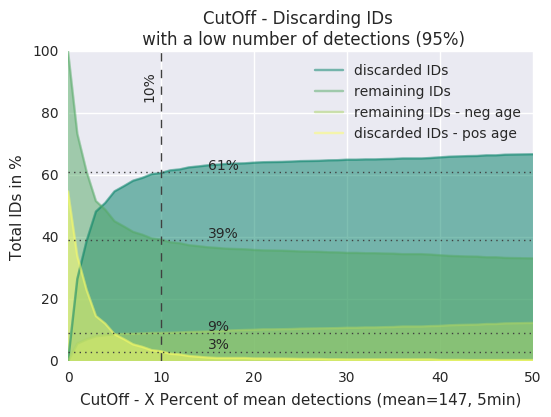

In [519]:
fig, ax = plt.subplots()
ax = dfmystat.plot(x='i', y=['muellidsP', 'restidsP','posP', 'negP'], stacked=False, kind='area', alpha=0.5, ax=ax, colormap='summer', xlim=(0,50))
ax.legend(['discarded IDs', 'remaining IDs', 'remaining IDs - neg age', 'discarded IDs - pos age'])
ax.set_xlabel('CutOff - X Percent of mean detections (mean=147, 5min)')
ax.set_ylabel('Total IDs in %')
ax.set_title('CutOff - Discarding IDs \n with a low number of detections (95%)')

plt.axvline(10, color='0.25', linestyle='dashed', linewidth=1)
plt.text(8,90,'10%',rotation=90)

plt.axhline(3, color='0.25', linestyle='dotted', linewidth=1)
plt.text(15,4,'3%',rotation=0)

plt.axhline(9, color='0.25', linestyle='dotted', linewidth=1)
plt.text(15,10,'9%',rotation=0)

plt.axhline(61, color='0.25', linestyle='dotted', linewidth=1)
plt.text(15,62,'61%',rotation=0)

plt.axhline(39, color='0.25', linestyle='dotted', linewidth=1)
plt.text(15,40,'39%',rotation=0)

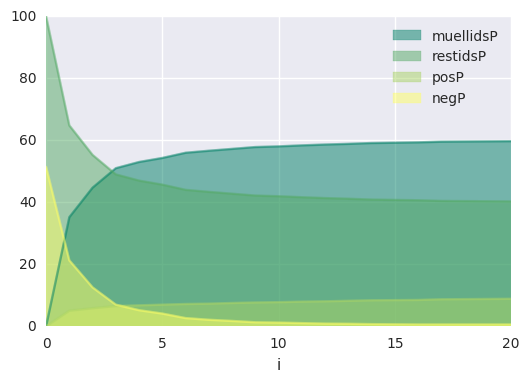

In [454]:
fig, ax = plt.subplots()
ax = dfmystat.plot(x='i', y=['muellidsP', 'restidsP','posP', 'negP'], stacked=False, kind='area', alpha=0.5, ax=ax, colormap='summer', xlim=(0,20))

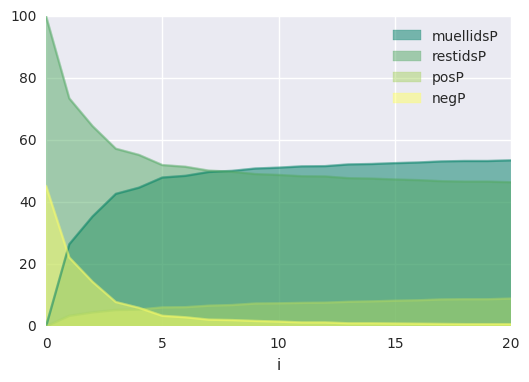

In [424]:
fig, ax = plt.subplots()
ax = dfmystat.plot(x='i', y=['muellidsP', 'restidsP','posP', 'negP'], stacked=False, kind='area', alpha=0.5, ax=ax, colormap='summer', xlim=(0,20))

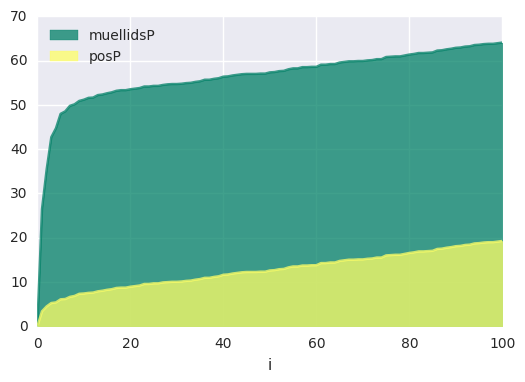

In [417]:
fig, ax = plt.subplots()
ax = dfmystat.plot(x='i', y=['muellidsP', 'posP'], stacked=False, kind='area', alpha=0.75, ax=ax, colormap='summer', xlim=(0,100))

In [562]:
def removeDetections(df, cutoff=10):
    idstat = df.groupby(by='id').size()
    m = idstat.mean()
    boder = cutoff*m/100
    keepIDs = idstat[idstat >= border]
    keepIDs = list(keepIDs.index.values)
    
    # remove detections with trashIDs from df
    leftOver = side[side.id.isin(keepIds)]
    
    return leftOver

In [563]:
leftOver = removeDetections(side, 10)

In [565]:
leftOver.shape

(275924, 11)

In [566]:
side.shape[0]

(291468, 11)

In [ ]:
side.shape[0]-leftOver.shape[0]